## Instructions :

* Add a document to the Colab runtime files to chunk and rename it as ICT.pdf or change the code to match the relevant file path.
* The clustering of chunks were performed using the Best Matching Unit of the prompt and chunks within the matched BMU. Other clustering steps were performed only for experimenting.

In [ ]:
!pip install python-docx PyMuPDF pandas tiktoken sentence-transformers langchain

In [ ]:
import os
import io
import re
import base64
import logging
import fitz
import docx
import tiktoken
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import RecursiveCharacterTextSplitter
import numpy as np

# Vectorizer

In [ ]:
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [ ]:
model = SentenceTransformer('sentence-transformers/all-MiniLM-L6-v2')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

def read_pdf(pdf_b64):
    try:
        pdf_bytes = base64.b64decode(pdf_b64)
        stream = io.BytesIO(pdf_bytes)
        doc = fitz.open(stream=stream)
        return "\n".join([page.get_text("text") for page in doc])
    except Exception as e:
        logger.error(f"PDF read error: {e}")
        return ""

def chunk_text(text, max_tokens=384, overlap=50):
    splitter = RecursiveCharacterTextSplitter(
        chunk_size=max_tokens,
        chunk_overlap=overlap,
        separators=["\n\n", "\n", " "],
        length_function=lambda txt: len(tiktoken.get_encoding("cl100k_base").encode(txt))
    )
    return splitter.split_text(text)

def embed_text_chunks(chunks):
    return model.encode(chunks)

def create_embeddings(pdf_file):
    with open(pdf_file, "rb") as f:
        b64_content = base64.b64encode(f.read()).decode('utf-8')
    raw_text = read_pdf(b64_content)
    cleaned = clean_text(raw_text)
    chunks = chunk_text(cleaned)
    embeddings = embed_text_chunks(chunks)
    print("Embeddings shape:", embeddings.shape)
    return chunks,embeddings

In [ ]:
chunks,embeddings=create_embeddings("ICT.pdf")

Embeddings shape: (155, 384)


In [ ]:
chunks[:3]

['Information and Communication Technology Teachers Guide Grade 12 Effective from 2017 Department of Information Technology National Institute of Education Maharagama Sri Lanka wwwnielk Information and Communication Technology Grade 12  Teachers Guide  National Institute of Education First print 2017 ISBN Department of Information Technology Faculty of Science and Technology National Institute of Education Maharagama wwwnielk Printed by i CONTENTS Page No 10 Message from the Director General ii 20 Message from the Deputy Director General iii 30 Curriculum Committee ivv 40 Introduction vi 50 Common National Goals vii 60 Basic Competencies viiix 70 Objectives of the Subject xi 80 Proposed number of periods for each units xii 90 Syllabus 1  27 100 Learning Teaching process 28 191 110 School Policies and Programs 192 120 Assessment and Evaluation 193 ii Message from the Director General With the primary objective of realizing the National Educational Goals recommended by the National Educa

In [ ]:
embeddings[:3]

array([[-0.00539549,  0.01799691, -0.07062975, ...,  0.01654691,
        -0.02608517, -0.02043968],
       [-0.08843452, -0.00522241, -0.04135546, ..., -0.03346817,
        -0.0266348 ,  0.028532  ],
       [-0.03059755,  0.02607359, -0.00828715, ...,  0.01989921,
        -0.08354416, -0.02624068]], dtype=float32)

# Applying SOM

In [ ]:
!pip3 install --upgrade git+https://github.com/GayuniBas2001/SOMPY_sevamoo.git

  Cloning https://github.com/GayuniBas2001/SOMPY_sevamoo.git to /tmp/pip-req-build-n01r_gqg
  Running command git clone --filter=blob:none --quiet https://github.com/GayuniBas2001/SOMPY_sevamoo.git /tmp/pip-req-build-n01r_gqg
  Resolved https://github.com/GayuniBas2001/SOMPY_sevamoo.git to commit 53e89a5351bfacfa48e7153f3510af35498e18c9
  Preparing metadata (setup.py) ... done
  Created wheel for SOMPY: filename=SOMPY-1.1.1-py3-none-any.whl size=29178 sha256=f715f224d3d1a701af78066e4d6207b582de0e7a3df57f4af222c9dad8a588c8
  Stored in directory: /tmp/pip-ephem-wheel-cache-4runl6r8/wheels/fc/dd/d6/26375a31b7c69ce2502112a68ead58548f7caa4102897a065d
Successfully built SOMPY


The training length for rough and fine-tune training in SOM (Self-Organizing Maps) depends on:

* The size of the dataset (number of samples)

* The map size (number of nodes)

* Whether your goal is speed vs. accuracy

In [ ]:
from sklearn.datasets import load_iris
import numpy as np
from math import sqrt

data = embeddings
data = np.array(data)

n_samples = len(data)
rough_len = 1000 #int(5 * sqrt(n_samples))
finetune_len = int(20 * sqrt(n_samples))

print(f"Rough training length: {rough_len}")
print(f"Fine-tuning length: {finetune_len}")

Rough training length: 1000
Fine-tuning length: 248


### Important Note:
Based on Kohonen's insights and common practices:

- **Rough Training Phase**:
    - **Neighborhood Radius**: Start with a large radius (e.g., half the grid's maximum dimension).
    - **Iterations**: Approximately 1,000 iterations are often sufficient.
- **Fine-Tuning Phase**:
    - **Neighborhood Radius**: Gradually decrease to a small value (e.g., 0.1 times the grid's maximum dimension).
    - **Iterations**: Typically, 10 to 50 times the number of neurons in the map. For instance, for a 10×10 map (100 neurons), consider 1,000 to 5,000 iterations.

In [ ]:
from sompy.sompy import SOMFactory

#### Selecting optimal parameter values

In [ ]:
# #Define function to calculate BMU using euclidean distance
# def euc_quantication_error(data, sm):
#     bmu_vectors = sm.codebook.matrix[sm._bmu[0].astype(int)]
#     return np.mean(np.linalg.norm(data - bmu_vectors, axis=1))

#Define function to calculate BMU using euclidean distance
def calculate_quantization_error(codebook_matrix,data):
    neuron_values = codebook_matrix
    quantization_error = np.mean(np.sqrt(np.sum((neuron_values - data) ** 2, axis=1)))
    return quantization_error

In [ ]:
# # Define parameter grids
# mapsizes = [(10, 10), (20, 20), (30, 30), (40, 40)]
# normalizations = ['var']
# initializations = ['random', 'pca']
# lattices = ['rect', 'hexa']
# neighborhoods = ['gaussian', 'bubble']

# # Store results
# results = []
# topo_errors = []
# quant_errors = []

# test_index = 0  # To track test case index
# test_indices = []

# # Iterate over all combinations
# for mapsize in mapsizes:
#     # Calculate fine-tuning length
#     neurons = mapsize[0]*mapsize[1]
#     finetune_lengths = [(10*neurons)] #,(20*neurons),(30*neurons),(40*neurons),(50*neurons)

#     for finetune_len in finetune_lengths:
#         for norm in normalizations:
#             for init in initializations:
#                 for lattice in lattices:
#                     for neighborhood in neighborhoods:
#                         if init == 'pca' and neighborhood == 'bubble':
#                             continue
#                         # Build and train SOM
#                         sm = SOMFactory().build(
#                             data,
#                             mapsize=mapsize,
#                             normalization=norm,
#                             initialization=init,
#                             lattice=lattice,
#                             neighborhood=neighborhood
#                         )
#                         sm.train(
#                             n_job=1,
#                             verbose=False,
#                             train_rough_len=rough_len,
#                             train_finetune_len=finetune_len)

#                         # Calculate errors
#                         topographic_error = sm.calculate_topographic_error()
#                         # quantization_error = np.mean(sm._bmu[1])
#                         som_lib_quantization_error = sm.calculate_quantization_error()

#                         # Store the results
#                         results.append({
#                             'test_index': test_index,
#                             'mapsize': mapsize,
#                             'finetune_len': finetune_len,
#                             'normalization': norm,
#                             'initialization': init,
#                             'lattice': lattice,
#                             'neighborhood': neighborhood,
#                             'topographic_error': topographic_error,
#                             # 'quantization_error': quantization_error,
#                             'som_lib_quantization_error': som_lib_quantization_error
#                         })

#                         # Append for plotting
#                         test_indices.append(test_index)
#                         topo_errors.append(topographic_error)
#                         quant_errors.append(som_lib_quantization_error)

#                         # Print the results
#                         print(f"[{test_index}] mapsize: {mapsize}, finetune_length: {finetune_len},normalization: {norm}, initialization: {init}, "
#                               f"lattice: {lattice}, neighborhood: {neighborhood} => "
#                               f"Topographic error: {topographic_error:.4f}, "
#                               # f"Quantization error: {quantization_error:.4f},"
#                               f"som_lib_quantization_error: {som_lib_quantization_error:.4f}")

#                         test_index += 1

[0] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.5675


/usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
  np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )


Based on the standard practices of the SOMpy library, it's likely that both our input data and the Best Matching Unit (BMU) weights are normalized during the training process.

In SOMpy, when we build the Self-Organizing Map (SOM) using the SOMFactory().build() method, we can specify the normalization method. For example:

`sm = som_fac.build(data, normalization='var', ...)`

Here, normalization='var' indicates that the data will be standardized using z-score normalization, where each feature is transformed to have a mean of 0 and a standard deviation of 1.

During training, the SOM adjusts its codebook vectors (weights) in the same normalized space as the input data. This ensures that distance calculations between data points and codebook vectors are meaningful and consistent.

In summary, unless we've explicitly disabled normalization, both your data and BMU weights are operating in a normalized space within SOMpy.

### Plotting errors for each parameter value conbination

In [ ]:
# # Plotting
# plt.figure(figsize=(12, 6))

# plt.plot(test_indices, topo_errors, label='Topographic Error', marker='o', linestyle='-')
# plt.plot(test_indices, quant_errors, label='Quantization Error', marker='s', linestyle='-')

# plt.xlabel('Test Case Index')
# plt.ylabel('Error')
# plt.title('Topographic and Quantization Errors Across Test Cases')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

In [ ]:
# rint("[0] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.5161, som_lib_quantization_error: 0.5680
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# [1] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.4919
# [2] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6290
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [3] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.4535
# [4] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.5699
# [5] mapsize: (10, 10), finetune_length: 1000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6287
# [6] mapsize: (10, 10), finetune_length: 2000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.0839, som_lib_quantization_error: 0.5720
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# [7] mapsize: (10, 10), finetune_length: 2000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 0.9419, som_lib_quantization_error: 0.4996
# [8] mapsize: (10, 10), finetune_length: 2000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6292
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [9] mapsize: (10, 10), finetune_length: 2000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.1097, som_lib_quantization_error: 0.4684
# [10] mapsize: (10, 10), finetune_length: 2000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.5699
# [11] mapsize: (10, 10), finetune_length: 2000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6287
# [12] mapsize: (10, 10), finetune_length: 3000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.3290, som_lib_quantization_error: 0.5666
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# [13] mapsize: (10, 10), finetune_length: 3000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 0.9484, som_lib_quantization_error: 0.4995
# [14] mapsize: (10, 10), finetune_length: 3000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6309
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [15] mapsize: (10, 10), finetune_length: 3000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.4321
# [16] mapsize: (10, 10), finetune_length: 3000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.5699
# [17] mapsize: (10, 10), finetune_length: 3000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6287
# [18] mapsize: (10, 10), finetune_length: 4000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.6710, som_lib_quantization_error: 0.5660
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# [19] mapsize: (10, 10), finetune_length: 4000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.5077
# [20] mapsize: (10, 10), finetune_length: 4000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.5032, som_lib_quantization_error: 0.6348
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [21] mapsize: (10, 10), finetune_length: 4000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.1097, som_lib_quantization_error: 0.4620
# [22] mapsize: (10, 10), finetune_length: 4000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.5699
# [23] mapsize: (10, 10), finetune_length: 4000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6287
# [24] mapsize: (10, 10), finetune_length: 5000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.4581, som_lib_quantization_error: 0.5719
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# [25] mapsize: (10, 10), finetune_length: 5000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 0.9806, som_lib_quantization_error: 0.5067
# [26] mapsize: (10, 10), finetune_length: 5000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6345
# [27] mapsize: (10, 10), finetune_length: 5000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.4784
# [28] mapsize: (10, 10), finetune_length: 5000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.5699
# [29] mapsize: (10, 10), finetune_length: 5000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.6287
# [30] mapsize: (20, 20), finetune_length: 4000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.0129, som_lib_quantization_error: 0.3837
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [31] mapsize: (20, 20), finetune_length: 4000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0266
# [32] mapsize: (20, 20), finetune_length: 4000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5643
# [33] mapsize: (20, 20), finetune_length: 4000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.0000, som_lib_quantization_error: 0.7999
# [34] mapsize: (20, 20), finetune_length: 4000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.3748
# [35] mapsize: (20, 20), finetune_length: 4000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5437
# [36] mapsize: (20, 20), finetune_length: 8000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.9935, som_lib_quantization_error: 0.3751
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [37] mapsize: (20, 20), finetune_length: 8000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0000
# [38] mapsize: (20, 20), finetune_length: 8000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5779
# [39] mapsize: (20, 20), finetune_length: 8000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.0000, som_lib_quantization_error: 0.7999
# [40] mapsize: (20, 20), finetune_length: 8000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.3748
# [41] mapsize: (20, 20), finetune_length: 8000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5437
# [42] mapsize: (20, 20), finetune_length: 12000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.8516, som_lib_quantization_error: 0.3854
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [43] mapsize: (20, 20), finetune_length: 12000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0085
# [44] mapsize: (20, 20), finetune_length: 12000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.6387, som_lib_quantization_error: 0.5565
# [45] mapsize: (20, 20), finetune_length: 12000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.0000, som_lib_quantization_error: 0.7999
# [46] mapsize: (20, 20), finetune_length: 12000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.3748
# [47] mapsize: (20, 20), finetune_length: 12000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5437
# [48] mapsize: (20, 20), finetune_length: 16000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.9097, som_lib_quantization_error: 0.3811
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [49] mapsize: (20, 20), finetune_length: 16000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0044
# [50] mapsize: (20, 20), finetune_length: 16000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5695
# [51] mapsize: (20, 20), finetune_length: 16000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.0000, som_lib_quantization_error: 0.7999
# [52] mapsize: (20, 20), finetune_length: 16000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.3748
# [53] mapsize: (20, 20), finetune_length: 16000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5437
# [54] mapsize: (20, 20), finetune_length: 20000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.3841
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [55] mapsize: (20, 20), finetune_length: 20000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0000
# [56] mapsize: (20, 20), finetune_length: 20000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.4065, som_lib_quantization_error: 0.5595
# [57] mapsize: (20, 20), finetune_length: 20000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 0.0000, som_lib_quantization_error: 0.7999
# [58] mapsize: (20, 20), finetune_length: 20000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.3748
# [59] mapsize: (20, 20), finetune_length: 20000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5437
# [60] mapsize: (30, 30), finetune_length: 9000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 0.0452, som_lib_quantization_error: 0.1892
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [61] mapsize: (30, 30), finetune_length: 9000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 0.9935, som_lib_quantization_error: 0.0000
# [62] mapsize: (30, 30), finetune_length: 9000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0194, som_lib_quantization_error: 0.5136
# [63] mapsize: (30, 30), finetune_length: 9000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0082
# [64] mapsize: (30, 30), finetune_length: 9000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.1790
# [65] mapsize: (30, 30), finetune_length: 9000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.5871, som_lib_quantization_error: 0.4893
# [66] mapsize: (30, 30), finetune_length: 18000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.2016
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [67] mapsize: (30, 30), finetune_length: 18000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 0.9742, som_lib_quantization_error: 0.0060
# [68] mapsize: (30, 30), finetune_length: 18000,normalization: var, initialization: random, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, som_lib_quantization_error: 0.5169
# [69] mapsize: (30, 30), finetune_length: 18000,normalization: var, initialization: random, lattice: hexa, neighborhood: bubble => Topographic error: 1.0000, som_lib_quantization_error: 0.0061
# [70] mapsize: (30, 30), finetune_length: 18000,normalization: var, initialization: pca, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.1790
# [71] mapsize: (30, 30), finetune_length: 18000,normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.5871, som_lib_quantization_error: 0.4893
# [72] mapsize: (30, 30), finetune_length: 27000,normalization: var, initialization: random, lattice: rect, neighborhood: gaussian => Topographic error: 1.0000, som_lib_quantization_error: 0.1907
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:344: RuntimeWarning: invalid value encountered in sqrt
#   np.mean(np.sqrt(bmu[1] + fixed_euclidean_x2))) #lbugnon: ojo aca me tiró un warning, revisar (commit sinc: 965666d3d4d93bcf48e8cef6ea2c41a018c1cb83 )
# /usr/local/lib/python3.11/dist-packages/sompy/sompy.py:356: RuntimeWarning: invalid value encountered in sqrt
#   bmu[1] = np.sqrt(bmu[1] + fixed_euclidean_x2)
# [73] mapsize: (30, 30), finetune_length: 27000,normalization: var, initialization: random, lattice: rect, neighborhood: bubble => Topographic error: 0.9871, som_lib_quantization_error: 0.0000
# ")

In [ ]:
print("Selected parameter values : ")
print("mapsize: (20, 20), normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, Quantization error: 13.3839")
print("Number of chunks :", len(chunks))

Selected parameter values : 
mapsize: (20, 20), normalization: var, initialization: pca, lattice: hexa, neighborhood: gaussian => Topographic error: 0.0000, Quantization error: 13.3839
Number of chunks : 155


The normalization function used in SOMpy:

```python
def normalize(self, data):
    me, st = self._mean_and_standard_dev(data)
    st[st == 0] = 1
    return (data - me) / st
```

This is **z-score normalization**, also called **standardization**.

---

### 🔍 What does z-score normalization do?

For each feature (column) in the dataset:

* Subtract the mean
* Divide by the standard deviation

**Formula:**

$$
\text{normalized\_value} = \frac{x - \mu}{\sigma}
$$

---

### ✅ What is the range of the output?

There is **no fixed min-max range**, but typically:

* Most values will fall between **−3 and +3**, assuming the data is roughly normally distributed.
* The mean of each feature becomes **0**
* The standard deviation becomes **1**

So, the **normalized data is centered around 0** with unit variance.

---

### 🧠 Implication for SOM:

Using z-score normalization ensures:

* All features contribute **equally** regardless of their original scale.
* Helps the SOM form a balanced map rather than being biased toward high-magnitude features.


In [ ]:
from sompy.sompy import SOM
from sompy.sompy import SOMFactory

som_fac = SOMFactory()

sm = som_fac.build(data, mapsize=(20, 20), normalization='var', initialization='pca', lattice='hexa', neighborhood='gaussian')
sm.train(n_job=1, verbose=False, train_rough_len=rough_len, train_finetune_len=finetune_len)

topographic_error = sm.calculate_topographic_error()
quantization_error = sm.calculate_quantization_error()
print ("Topographic error = %s; Quantization error = %s" % (topographic_error, quantization_error))

Topographic error = 0.0; Quantization error = 0.5440437957241395


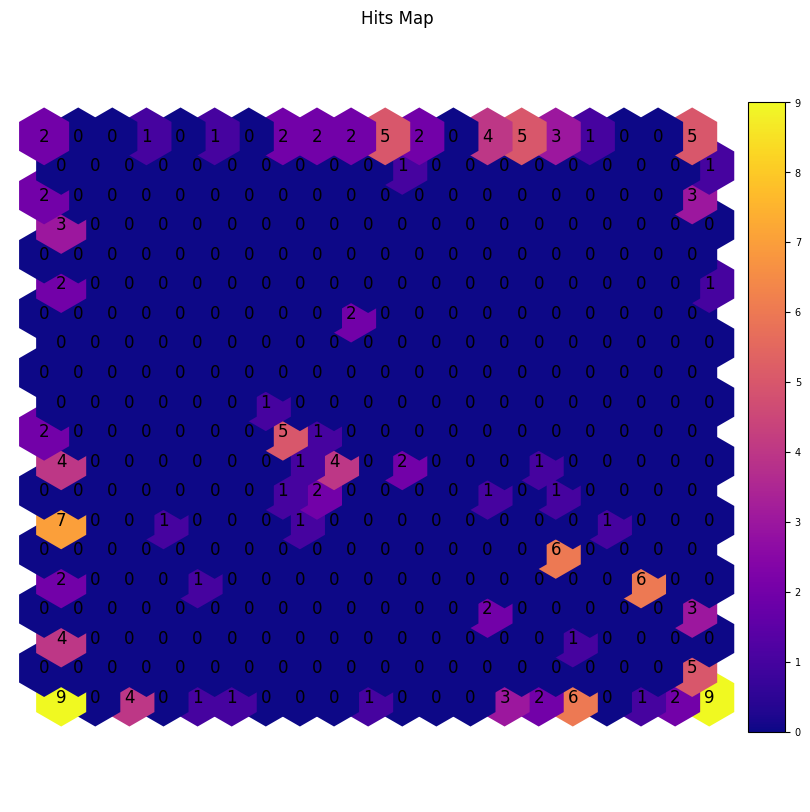

In [ ]:
from sompy.visualization.bmuhits import BmuHitsView

vhts  = BmuHitsView(10,10,"Hits Map",text_size=7)
vhts.show(sm, anotate=True, onlyzeros=False, labelsize=12, cmap="plasma", logaritmic=False)

#cmap options
# Sequential: 'viridis', 'plasma', 'inferno', 'magma', 'cividis', 'gray', 'binary'
# Diverging: 'coolwarm', 'bwr', 'seismic'
# Qualitative: 'tab10', 'tab20', 'tab20b', 'tab20c'

This Hits Map shows how many hits each node has gotten by the number on the node.

Exp : 9 chunks has the 400th node as their BMU (Best MAtching Unit)

In [ ]:
# Get BMUs (Best Matching Units) for each sample
bmu_indices = sm._bmu[0]  # Array of shape (n_samples,) containing index of BMU neuron
bmu_indices

array([ 20.,  20.,  20.,   0.,   0.,  20.,  20.,   0.,   4.,   6.,   0.,
         5., 139., 299., 386., 280.,  17.,  59., 359., 192., 171., 151.,
        66.,  82., 144.,  60.,   1.,   4.,   4.,   4.,   1.,   4., 171.,
       132.,   2.,   6., 179., 199., 139.,   6.,   4.,  95.,   0.,   0.,
         5.,   0.,   0.,   0.,  10., 339., 339., 339., 179., 139., 199.,
       179., 139.,  19.,  19., 139., 139., 139., 179., 396., 394., 390.,
       390., 389., 389., 389., 389., 389., 391., 369., 391., 392., 392.,
       399., 388., 388., 385., 385., 385., 385., 385., 340., 380., 380.,
       380., 360., 340., 340., 380., 380., 383., 384., 384., 384., 386.,
       386., 386., 299.,  17.,  19.,  19.,  17.,  99.,  17.,  99.,  19.,
        19.,  19.,  19.,  19.,  59.,  59.,  59., 136., 192., 192., 359.,
       399., 191., 192., 213., 171., 270., 270., 192., 172., 152., 151.,
       169., 169., 171.,  66.,  44., 104.,  82.,  82.,  82.,  82.,  82.,
       104.,  15., 104., 165., 123.,  14., 146., 10

* The BMU indices array shows the BMU index of each chunk

* Since we have 155 chunks, the length of the array is 155

* Because the map size is 20*20, the number of nodes in the map is 400. So the minimum and maximum BMU values are 0 and 399.

Why BMU Indices Are 1D in SOMPY

In SOMPY:

* The BMU indices stored in sm._bmu[0] are 1D indices referring to the flattened list of neurons.

* Even though the SOM map is 2D (20×20 = 400 neurons), each neuron is internally represented with a single integer index (0 to 399).

* This is done by flattening the 2D grid (row-major order) — so (i, j) becomes i * n_cols + j.

In [ ]:
map_width = sm.codebook.mapsize[1]  # e.g., 20

bmu_indices_1d = sm._bmu[0]
bmu_coords_2d = [(idx // map_width, idx % map_width) for idx in bmu_indices_1d]
bmu_coords_2d[:10]

[(np.float64(1.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(4.0)),
 (np.float64(0.0), np.float64(6.0))]

In [ ]:
#This gives the x,y 2D coordinates with the 1d bmu index for the specific data point
som_lib_bmu_coords_2d=sm.bmu_ind_to_xy(bmu_indices_1d)
som_lib_bmu_coords_2d[:10]

array([[ 1,  0, 20],
       [ 1,  0, 20],
       [ 1,  0, 20],
       [ 0,  0,  0],
       [ 0,  0,  0],
       [ 1,  0, 20],
       [ 1,  0, 20],
       [ 0,  0,  0],
       [ 0,  4,  4],
       [ 0,  6,  6]])

In [ ]:
chunks[20]

'MAC addresses and LAN technology o IPv4 addresses o Assigning IPs to networks  Subnetting  Subnet masks  CIDR notation  Private IP addresses  DHCP o Scarcity of IPv4 addresses and IPv6 as a solutionan overview  Finding the path to the destination o Routing and routers o Packet switching  Best effort delivery  Explains the role of a gateway device in inter connecting two LANs  Explain the need for a uniform MAC protocol independent addressing scheme and how IP addresses play that role  Describes the role of subnet masks  Calculates subnet masks and IP address ranges for a given block of IP addresses and network sizes  Describes how DHCP is used to dynamically assign IP addresses  Describes the role of routers in finding a suitable path from the sender to the receiver  Explains packet switching and best 6 20 Competency Competency Level Contents Learning outcomes Periods effort delivery in IP networks 68 Explores the role of transport protocols in the Internet  Delivering data from an ap

### Allocating BMUs for chunks

In [ ]:
chunks_BMU = [(chunk, int(bmu)) for chunk, bmu in zip(chunks, bmu_indices)]

# SOM Retrieval

In [ ]:
import numpy as np
from sentence_transformers import SentenceTransformer

In [ ]:
# ── 1) Prompt embedding function ───────────────────────────────────────────────
def embed_prompt(prompt: str,
                 model: SentenceTransformer = model) -> np.ndarray:
    """
    Turn a text prompt into a 384‑dim embedding using the same model
    you used for your chunks.
    """
    v = model.encode([prompt])
    return v[0]

# ── 2) Method to find the BMU index for a new vector ───────────────────────────
def find_bmu_for_vector(vec: np.ndarray, som_model) -> int:
    """
    Given a 1×D vector `vec`, find its Best Matching Unit in `som_model`
    without retraining. This matches what SOMPY does internally:

      1) Normalize `vec` with the SAME mean/std you used on the training data.
      2) Compute Euclidean distance from `vec` to every neuron weight.
      3) Return the index of the closest neuron (the BMU).
    """
    # 1) Ensure vec is shape (1, D)
    vec = vec.reshape(1, -1)

    # 2) Normalize using the training-data statistics
    #    normalize_by(raw_data, data_to_normalize) scales `data_to_normalize`
    #    by the mean/std of `raw_data` (see VarianceNormalizer in normalization.py) :contentReference[oaicite:0]{index=0}
    normed_vec = som_model._normalizer.normalize_by(som_model.data_raw, vec)

    # 3) Compute distances to all neuron weights (shape: [n_neurons, D])
    weights = som_model.codebook.matrix
    dists = np.linalg.norm(weights - normed_vec, axis=1)

    # 4) Return the BMU index
    return int(np.argmin(dists))

# ── 3) (Optional) Helper to get neighbor BMU indices in a 2D grid ─────────────
def get_neighbor_bmus(bmu_idx: int,
                      grid_shape: tuple[int,int],
                      radius: int = 1) -> set[int]:
    """
    Given the flattened BMU index and grid_shape=(n_rows, n_cols),
    return the set of BMU indices within `radius` (including the center).
    """
    n_rows, n_cols = grid_shape
    r, c = divmod(bmu_idx, n_cols)
    neighbors = set()
    for dr in range(-radius, radius+1):
        for dc in range(-radius, radius+1):
            rr, cc = r+dr, c+dc
            if 0 <= rr < n_rows and 0 <= cc < n_cols:
                neighbors.add(rr * n_cols + cc)
    return neighbors

# ── 4) Retrieval function ──────────────────────────────────────────────────────
def retrieve_relevant_chunks(
    prompt: str,
    chunks: list[str],
    embeddings: np.ndarray,
    bmu_indices: np.ndarray,
    som_model,
    grid_shape: tuple[int,int],
    neighbor_radius: int = 0,
    rerank_top_k: int = 5
) -> list[tuple[str, float]]:
    """
    1. Embed the prompt
    2. Find its BMU (and optionally neighbors)
    3. Collect all chunks assigned to those BMUs
    4. Rerank them by cosine similarity to the prompt embedding
    5. Return the top `rerank_top_k` as (chunk, score)
    """

    # a) Embed prompt and find BMU
    q_vec = embed_prompt(prompt)
    prompt_bmu = find_bmu_for_vector(q_vec, som_model)

    # b) Decide which BMUs to consider
    bmus_to_use = {prompt_bmu}
    if neighbor_radius > 0:
        bmus_to_use |= get_neighbor_bmus(prompt_bmu, grid_shape, neighbor_radius)

    # c) Gather candidate chunks + their embeddings
    candidates = []
    for chunk, emb, bmu in zip(chunks, embeddings, bmu_indices):
        if bmu in bmus_to_use:
            candidates.append((chunk, emb))

    # d) Rerank by cosine similarity
    def cosine(a, b):
        return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

    scored = [(chunk, cosine(q_vec, emb)) for chunk, emb in candidates]
    # sort descending by score
    scored.sort(key=lambda x: x[1], reverse=True)

    # e) Return top K
    return scored[:rerank_top_k]

In [ ]:
# ── 5) Example usage ───────────────────────────────────────────────────────────
def som_retrieve():
    prompt = "Describe the evolutions of Operating Systems"
    grid_shape = (20, 20)   # match your SOMFactory mapsize
    results = retrieve_relevant_chunks(
        prompt,
        chunks,
        embeddings,
        bmu_indices,
        sm,               # trained SOM model
        grid_shape,
        neighbor_radius=1,
        rerank_top_k=5
    )

    for txt, score in results:
        # print(f"[{score:.3f}]\t{txt[:80]}…")
        print(f"[{score:.3f}]\t{txt}")

som_retrieve()

[0.667]	Level 51 Defines the term computer operating system OS and investigates its need in computer systems Time 04 periods Learning Outcomes  Defines the computer operating system  Briefly describes the evolution of OS  Identifies the main functions and the abstractions directories files and data provided by the operating system to the user  Describes how the operating system manages the resources of a computer  Classifies the operating systems based on their users and tasks Contents  Introduction to computer Operating System  Evaluation of OS  Main functions of an operating system o providing interfaces o Process management o Resource management o Security and protection  Classification of operating systems o Single user  single task o Single user  multi task o Multi user  multi task o Multithreading o Real time o Time sharing systems Concepts and terms to be highlighted  Definition of operating system  Main functions of operating system  Classification of operating systems Guidance

# COSINE Retrieval

In [ ]:
local_data = [
    np.array([idx, chunk, emb], dtype=object)
    for idx, (chunk, emb) in enumerate(zip(chunks, embeddings))
]
local_data[:3]

[array([0,
        'Information and Communication Technology Teachers Guide Grade 12 Effective from 2017 Department of Information Technology National Institute of Education Maharagama Sri Lanka wwwnielk Information and Communication Technology Grade 12  Teachers Guide  National Institute of Education First print 2017 ISBN Department of Information Technology Faculty of Science and Technology National Institute of Education Maharagama wwwnielk Printed by i CONTENTS Page No 10 Message from the Director General ii 20 Message from the Deputy Director General iii 30 Curriculum Committee ivv 40 Introduction vi 50 Common National Goals vii 60 Basic Competencies viiix 70 Objectives of the Subject xi 80 Proposed number of periods for each units xii 90 Syllabus 1  27 100 Learning Teaching process 28 191 110 School Policies and Programs 192 120 Assessment and Evaluation 193 ii Message from the Director General With the primary objective of realizing the National Educational Goals recommended by 

In [ ]:
# cursor = conn.cursor()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def search_similar_chunks_local(query: str,
                                data_array: list[np.ndarray],
                                top_k: int = 5):
    query_embedding = model.encode(query)
    # cursor.execute("SELECT id, text_chunk, embedding FROM document_embeddings")
    # results = cursor.fetchall()
    results = data_array
    scored = []
    for _id, chunk, emb in results:
        sim = cosine_similarity(query_embedding, np.array(emb))
        scored.append((sim, chunk))
    scored.sort(reverse=True)
    return [chunk for _, chunk in scored[:top_k]]

In [ ]:
def cos_retrieve():
    results = search_similar_chunks_local(
    "Describe the evolutions of Operating Systems",
    local_data,
    top_k=5
    )
    for txt in results:
        print(txt)

cos_retrieve()

Level 51 Defines the term computer operating system OS and investigates its need in computer systems Time 04 periods Learning Outcomes  Defines the computer operating system  Briefly describes the evolution of OS  Identifies the main functions and the abstractions directories files and data provided by the operating system to the user  Describes how the operating system manages the resources of a computer  Classifies the operating systems based on their users and tasks Contents  Introduction to computer Operating System  Evaluation of OS  Main functions of an operating system o providing interfaces o Process management o Resource management o Security and protection  Classification of operating systems o Single user  single task o Single user  multi task o Multi user  multi task o Multithreading o Real time o Time sharing systems Concepts and terms to be highlighted  Definition of operating system  Main functions of operating system  Classification of operating systems Guidance for les

##Next Steps :
* Visualize the quantization error to identify the severity
* Perform k means to find top k BMUs rather than only 1 BMU

## Visualize the quantization error to identify the severity

#### **✅ Our Understanding — Confirmed & Clarified**

"The data points are initially in high dimensional space. The 2D topology/map is wrapped around the data to get closer to the data points."
* ✔️ Correct.

"In this process, the position of the data points are not changing, only the node positions (BMUs) are changing in the high-dimensional space."
* ✔️ Correct again. Data remains fixed; SOM nodes move in high-dimensional space to match the data distribution.

"Quantization error is quantifying the error distance between data points and their closest SOM node."
* ✔️ Perfect. It’s the average Euclidean distance between each input vector and its BMU weight vector (codebook vector).

1. 📊 How to Visualize the Quantization Error

a. Scatter Plot of Quantization Error per Sample

Plot how far each point is from its BMU.

In [ ]:
map_width = sm.codebook.mapsize[1]  # e.g., 20

bmu_indices_1d = sm._bmu[0]
bmu_coords_2d = [(idx // map_width, idx % map_width) for idx in bmu_indices_1d]
bmu_coords_2d[:10]

[(np.float64(1.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(1.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(0.0)),
 (np.float64(0.0), np.float64(4.0)),
 (np.float64(0.0), np.float64(6.0))]

In [ ]:
sm._bmu[0][0].dtype

dtype('float64')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get BMU weight vectors (high-dimensional)
neuron_values = sm.codebook.matrix[sm._bmu[0].astype(int)]

# Compute quantization errors for each sample
quantization_errors = np.linalg.norm(data - bmu_vectors, axis=1) #Here we're taking the euclidean norm (or magnitude) along each row

# Plot
plt.figure(figsize=(10, 4))
plt.plot(quantization_errors, marker='o', linestyle='')
plt.title('Quantization Error for Each Sample')
plt.xlabel('Sample Index')
plt.ylabel('Euclidean Distance to BMU')
plt.grid(True)
plt.show()

* sm._bmu[0] is an array of BMU indices — one index per sample.

* sm.codebook.matrix is a matrix of shape (n_nodes, n_features) — each row is a neuron's position in high-dimensional space.

* So sm.codebook.matrix[sm._bmu[0]] gives you an array of shape (n_samples, n_features) — the BMU vector (i.e., the neuron's weight) that each sample got mapped to.

**Weight Vector**

* Each neuron (node) in the SOM grid has a weight vector, which is a point in the original feature space (same dimensionality as your data). That’s the neuron's position in the high-dimensional space.

* Even though the SOM is a 2D grid visually, the nodes themselves “live” in the data's feature space.

* During training, these vectors (weights) are updated to get closer to nearby data points.

* weight vector = position of the node in high-dimensional space.

In [ ]:
neuron_values

array([[-0.245518,  0.596945,  0.445224, ..., -0.973499, -0.595096,
         0.01117 ],
       [-0.245518,  0.596945,  0.445224, ..., -0.973499, -0.595096,
         0.01117 ],
       [-0.245518,  0.596945,  0.445224, ..., -0.973499, -0.595096,
         0.01117 ],
       ...,
       [-0.052044,  0.037891,  0.032418, ..., -0.56798 ,  0.395356,
         0.765358],
       [-0.379371,  0.611926,  0.355033, ..., -0.54595 , -0.400019,
         0.377037],
       [-0.379371,  0.611926,  0.355033, ..., -0.54595 , -0.400019,
         0.377037]])

In [ ]:
neuron_values.shape

(155, 384)

In [ ]:
sm._data

array([[ 0.18880248,  0.26471484, -0.57631046, ..., -0.6104693 ,
        -0.9116158 , -0.24147697],
       [-1.8185698 , -0.294386  ,  0.1892385 , ..., -1.8615263 ,
        -0.9241936 ,  1.1092962 ],
       [-0.42042834,  0.45919436,  1.0540044 , ..., -0.5266163 ,
        -2.2264986 , -0.40148443],
       ...,
       [-0.4746899 ,  0.3080123 ,  0.11147743, ..., -0.7870753 ,
         0.44222328,  1.2133061 ],
       [-0.68682534,  1.7234899 ,  1.1463143 , ..., -1.2369212 ,
        -1.019859  ,  0.44665843],
       [-0.32508627,  0.24290141, -0.19468717, ...,  1.0066882 ,
        -0.8336944 , -0.2135052 ]], dtype=float32)

In [ ]:
quantization_errors.shape

(155, 384)

### Clustering using SOM (not required)

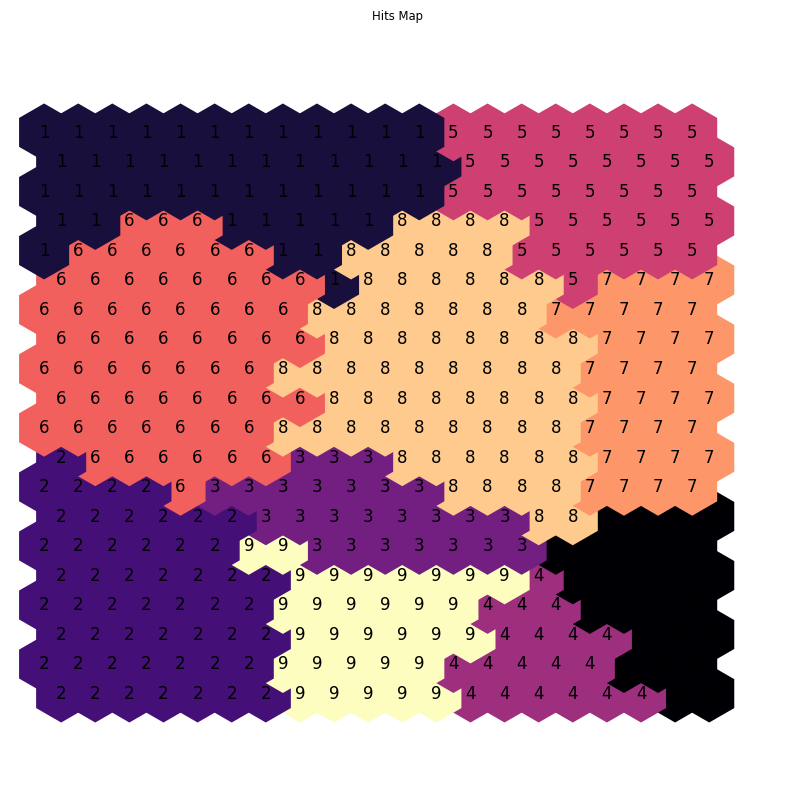

In [ ]:
from sompy.visualization.hitmap import HitMapView

sm_clustered=sm.cluster(10)
hits=HitMapView(10,10,"Hits Map",text_size=7)
hits_plot=hits.show(sm, anotate=True, onlyzeros=False, cmap="magma", labelsize=12)

In [ ]:
# Get cluster labels for each neuron (from the clustering)
neuron_cluster_labels = sm.cluster_labels  # Array of shape (n_neurons,) = (100,) for 10x10 grid

# Assign the cluster label to each sample based on its BMU neuron
sample_cluster_labels = [neuron_cluster_labels[int(bmu)] for bmu in bmu_indices]
# Ensure sample_cluster_labels is a NumPy array
sample_cluster_labels = np.array(sample_cluster_labels).reshape(-1, 1)

# Concatenate cluster labels as a new column
data_with_clusters = np.hstack((data, sample_cluster_labels))

In [ ]:
 #Print methids and attributes of som model
dir(sm)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batchtrain',
 '_bmu',
 '_calculate_ms_and_mpd',
 '_component_names',
 '_data',
 '_dim',
 '_distance_matrix',
 '_dlabel',
 '_dlen',
 '_normalizer',
 'bmu_ind_to_xy',
 'build_component_names',
 'build_data_labels',
 'calculate_map_dist',
 'calculate_map_size',
 'calculate_quantization_error',
 'calculate_topographic_error',
 'cluster',
 'cluster_labels',
 'codebook',
 'component_names',
 'data_labels',
 'data_raw',
 'find_bmu',
 'find_k_nodes',
 'finetune_train',
 'initialization',
 'mapshape',
 'mask',
 'name',
 'neighborhood',
 'node_activation',
 'predict',
 'predict_by',
 'predict_probability',
 'proj

In [ ]:
dir(sm._normalizer)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_mean_and_standard_dev',
 'denormalize_by',
 'name',
 'normalize',
 'normalize_by']

In SOMPY, the `_normalizer` object provides methods to handle data normalization, which is crucial for effective training of Self-Organizing Maps (SOMs). The two primary methods offered are `normalize` and `normalize_by`, each serving distinct purposes in the normalization process.

---

### 🔹 `normalize(data)`
The `normalize` method is used to standardize the training data before feeding it into the SOMThis process typically involves scaling the data so that each feature has a mean of zero and a standard deviation of one, or adjusting the data to a specific rangeNormalization ensures that all features contribute equally to the training process, preventing features with larger scales from dominating the learning
For example, if you're training your SOM with a dataset `trainingDataMatrix`, you would apply

```python
normalized_data = somModel._normalizer.normalize(trainingDataMatrix)
```
This step is essential to prepare the data appropriately for the SOM's learning algorithm

---

### 🔹 `normalize_by(raw_data, data_to_normalize)`
The `normalize_by` method is designed to apply the normalization parameters derived from one dataset (`raw_data`) to another dataset (`data_to_normalize`. This is particularly useful when you have new data that you want to project onto an already trained SOM, ensuring consistency in the data's scale and distributio.
For instance, if you have new data `newDataMatrix` and you want to normalize it using the parameters from your original training data `trainingDataMatrix`, you would us:

```python
normalized_new_data = somModel._normalizer.normalize_by(trainingDataMatrix, newDataMatrix)
``

This ensures that the new data is scaled in the same way as the training data, allowing for accurate mapping onto the existing SO.

---

### ✅ Summary
`normalize`      | Standardizes the training data                    | Preparing data before training the SOM

`normalize_by`   | Applies training data's normalization to new data | Projecting new data onto a trained SOM